## Generate unfocused radargram using `unfoc`

This notebook uses the UTIG `unfoc` library to generate and plot unfocused radargrams with
time information from the GPS stream.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pandas as pd
from pathlib import Path
from scipy.interpolate import interp1d

import unfoc

from utig_radar_loading import file_util, stream_util, geo_util

### Find a file to process

In [3]:
use_cache = True
cache_dir = "outputs/file_index.csv"
base_path = "/kucresis/scratch/data/UTIG"

df_files = file_util.load_file_index_df(base_path, cache_dir, read_cache=use_cache)
df_artifacts = file_util.create_artifacts_df(df_files)

Reading from cache file outputs/file_index.csv


In [4]:
r_prj, r_set, r_trn = 'ASB', 'JKB2s', 'GL0107b'
df_filt = df_artifacts[
    (df_artifacts['prj'] == r_prj) &
    (df_artifacts['set'] == r_set) &
    (df_artifacts['trn'] == r_trn)
]
df_filt_rad = df_filt[df_filt['stream'].isin(['RADnh5'])]
df_filt_gps = df_filt[df_filt['stream'].isin(['GPSnc1', 'GPStp2'])]

df_filt

,dataset,processing_level,processing_type,prj,set,trn,stream,full_path,artifact
8,UTIG2,orig,xlob,ASB,JKB2s,GL0107b,RADnh5,/kucresis/scratch/data/UTIG/UTIG2/orig/xlob/AS...,"(orig, xlob, RADnh5)"
228,UTIG2,targ,pcor,ASB,JKB2s,GL0107b,AQNnr1,/kucresis/scratch/data/UTIG/UTIG2/targ/pcor/AS...,"(targ, pcor, AQNnr1)"
229,UTIG2,targ,pcor,ASB,JKB2s,GL0107b,AVNcp1,/kucresis/scratch/data/UTIG/UTIG2/targ/pcor/AS...,"(targ, pcor, AVNcp1)"
230,UTIG2,targ,pcor,ASB,JKB2s,GL0107b,AVNcp2,/kucresis/scratch/data/UTIG/UTIG2/targ/pcor/AS...,"(targ, pcor, AVNcp2)"
231,UTIG2,targ,pcor,ASB,JKB2s,GL0107b,AVNnt2,/kucresis/scratch/data/UTIG/UTIG2/targ/pcor/AS...,"(targ, pcor, AVNnt2)"
232,UTIG2,targ,pcor,ASB,JKB2s,GL0107b,GPSkc1,/kucresis/scratch/data/UTIG/UTIG2/targ/pcor/AS...,"(targ, pcor, GPSkc1)"
233,UTIG2,targ,pcor,ASB,JKB2s,GL0107b,GPSnc1,/kucresis/scratch/data/UTIG/UTIG2/targ/pcor/AS...,"(targ, pcor, GPSnc1)"
234,UTIG2,targ,pcor,ASB,JKB2s,GL0107b,LASrz1,/kucresis/scratch/data/UTIG/UTIG2/targ/pcor/AS...,"(targ, pcor, LASrz1)"
235,UTIG2,targ,pcor,ASB,JKB2s,GL0107b,MAGgm2,/kucresis/scratch/data/UTIG/UTIG2/targ/pcor/AS...,"(targ, pcor, MAGgm2)"
236,UTIG2,targ,pcor,ASB,JKB2s,GL0107b,MAGim1,/kucresis/scratch/data/UTIG/UTIG2/targ/pcor/AS...,"(targ, pcor, MAGim1)"


In [5]:
if len(df_filt_rad) > 1:
    raise Exception('More filtering needed to get a single file')

artifact = df_filt_rad.iloc[0]
data_dir = Path(artifact['full_path']).parent
bxds_file_path = data_dir / "bxds"
if bxds_file_path.exists():
    print(f"Found bxds file to load at: {bxds_file_path}")
    stream_type = unfoc.read.get_radar_stream(bxds_file_path)
    print(f"Detected stream type: {stream_type}")
    radar_instrument, channels = unfoc.read.get_radar_type(bxds_file_path)
    print(f"Detected radar instrument: {radar_instrument}, channels: {channels}")

Found bxds file to load at: /kucresis/scratch/data/UTIG/UTIG2/orig/xlob/ASB/JKB2s/GL0107b/RADnh5/bxds
Detected stream type: RADnh5
Detected radar instrument: MARFA, channels: [1, 2, 3, 4]


In [6]:
unfoc.unfoc(
    infile=str(bxds_file_path),
    outdir='outputs/unfoc_scratch/',
    stackdepth=10, incodepth=5,
    channels='LoResInco1,LoResInco2',
    processes=2,
    output_samples=3200,
    blanking=50,
    bandpass=False
    )


### Load and align GPS data with radar data

In [7]:
ct_df = stream_util.load_ct_file(bxds_file_path)
gps_path = df_filt_gps.iloc[0]['full_path']
gps_df = stream_util.load_gzipped_stream_file(gps_path, parse=True, parse_kwargs={'use_ct': True})

# Nearest neighbor interpolation of GPS data to CT data using tim as common index

# Create nearest neighbor interpolators for each GPS field
lat_interp = interp1d(gps_df['tim'].values, gps_df['LAT'].values, kind='nearest', fill_value='extrapolate')
lon_interp = interp1d(gps_df['tim'].values, gps_df['LON'].values, kind='nearest', fill_value='extrapolate')
timestamp_interp = interp1d(gps_df['tim'].values, gps_df['TIMESTAMP'].values, kind='nearest', fill_value='extrapolate')

# Interpolate GPS data to CT tim values
ct_df['LAT'] = lat_interp(ct_df['tim'].values)
ct_df['LON'] = lon_interp(ct_df['tim'].values)
ct_df['TIMESTAMP'] = timestamp_interp(ct_df['tim'].values)
ct_df['TIMESTAMP'] = pd.to_datetime(ct_df['TIMESTAMP'], unit='ns')
ct_df = ct_df.set_index('seq')

print(f"Interpolated {len(ct_df)} CT records with GPS data")
ct_df.head()

Interpolated 925062 CT records with GPS data


,prj,set,trn,clk_y,clk_n,clk_d,clk_h,clk_m,clk_s,clk_f,tim,LAT,LON,TIMESTAMP
seq,,,,,,,,,,,,,,
3587,ASB,JKB2s,GL0107b,2018,1,5,4,6,31,51,1104239,-66.32118,109.5875,2018-01-01 03:56:22
3588,ASB,JKB2s,GL0107b,2018,1,5,4,6,31,51,1104244,-66.32118,109.5875,2018-01-01 03:56:22
3589,ASB,JKB2s,GL0107b,2018,1,5,4,6,31,51,1104738,-66.32118,109.5875,2018-01-01 03:56:22
3590,ASB,JKB2s,GL0107b,2018,1,5,4,6,31,51,1104744,-66.32118,109.5875,2018-01-01 03:56:22
3591,ASB,JKB2s,GL0107b,2018,1,5,4,6,31,52,1105273,-66.32118,109.5875,2018-01-01 03:56:22


### Plot radargram

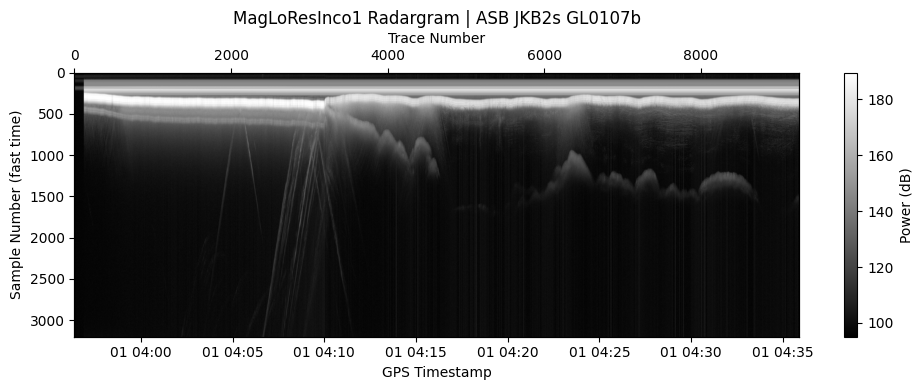


Radargram dimensions: 9250 traces x 3200 samples
Time span: 39 minutes


In [8]:
# Load and plot MagLoResInco1 with time axis
# Read trace numbers to map radar columns to CT records
trace_file = Path('outputs/unfoc_scratch/TraceNumbers1')
with open(trace_file, 'r') as f:
    trace_numbers = [int(line.strip()) for line in f]

# Read the metadata file to extract parameters
meta_file = Path('outputs/unfoc_scratch/MagLoResInco1.meta')
with open(meta_file, 'r') as f:
    meta_lines = f.readlines()
    
# Parse metadata header
metadata = {}
for line in meta_lines:
    if line.startswith('#'):
        if '=' in line:
            key, value = line[1:].split('=', 1)
            metadata[key.strip()] = value.strip().strip('"')
    else:
        break

# Read the binary magnitude data file
data_file = Path('outputs/unfoc_scratch/MagLoResInco1')
file_size = data_file.stat().st_size
bytes_per_value = 4
total_values = file_size // bytes_per_value
num_traces = len(trace_numbers)
num_samples = total_values // num_traces

# Read and convert the data
with open(data_file, 'rb') as f:
    binary_data = f.read()
    
# Convert from big-endian int32 to float
magscale = int(metadata.get('Scale', '20000'))
data_int = np.frombuffer(binary_data, dtype='>i4').reshape(num_traces, num_samples)
data = 10.0 ** (data_int.astype(np.float32) / magscale)
data_db = 20 * np.log10(data + 1e-10)

# Get timestamps for each trace from ct_df
trace_timestamps = np.array(ct_df.loc[trace_numbers]['TIMESTAMP'])


# Create figure with radar plot and time axis
fig, ax = plt.subplots(figsize=(10, 4))

# Plot radargram with time axis
extent = [trace_timestamps[0], trace_timestamps[-1], num_samples, 0]
im = ax.imshow(data_db.T, aspect='auto', cmap='gray',
               extent=extent,
               vmin=np.percentile(data_db, 5),
               vmax=np.percentile(data_db, 99.9))

# Format x-axis as time
ax.set_xlabel('GPS Timestamp')
ax.set_ylabel('Sample Number (fast time)')
ax.set_title(f'MagLoResInco1 Radargram | {r_prj} {r_set} {r_trn}')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Power (dB)')

# Add secondary x-axis with trace numbers
ax2 = ax.twiny()
ax2.set_xlim(0, num_traces)
ax2.set_xlabel('Trace Number')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nRadargram dimensions: {num_traces} traces x {num_samples} samples")
print(f"Time span: {(trace_timestamps[-1] - trace_timestamps[0]).astype('timedelta64[m]')}")